In [109]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
outputs = {}
for d in os.listdir('../jnk1/off/'):
    pair = tuple([int(i) for i in d[3:].split('to')])
    outputs[pair] = d
    
jnk1_ligands = [i for i in range(21)]
all_results = {i:{} for i in jnk1_ligands}
oldnew = {0:'old',1:'new'}

In [115]:
for ligand in jnk1_ligands:
    for output in outputs.keys():
        if ligand in output:
            endstate = oldnew[output.index(ligand)]
            solventfile = f'../jnk1/off/{outputs[output]}/{endstate}_solvent.npy'
            if os.path.exists(solventfile):
                solvent = np.load(solventfile,allow_pickle=True).flatten()[0]
                all_results[ligand][f'solvent-{outputs[output]}'] = solvent
            complexfile = f'../jnk1/off/{outputs[output]}/{endstate}_complex.npy'
            if os.path.exists(complexfile):
                complex = np.load(complexfile,allow_pickle=True).flatten()[0]
                all_results[ligand][f'complex-{outputs[output]}'] = complex

ligand: 0
ligand: 1
ligand: 2
ligand: 3
ligand: 4
ligand: 5
ligand: 6
ligand: 7
ligand: 8
ligand: 9
ligand: 10
ligand: 11
ligand: 12
ligand: 13
ligand: 14
ligand: 15
ligand: 16
ligand: 17
ligand: 18
ligand: 19
ligand: 20


No handles with labels found to put in legend.


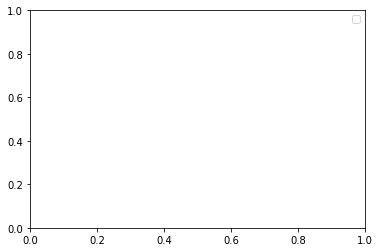

No handles with labels found to put in legend.


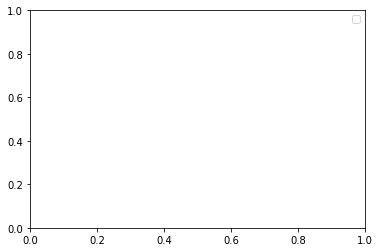

No handles with labels found to put in legend.


2


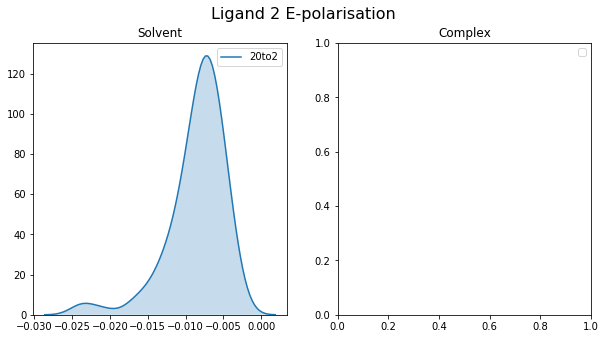

No handles with labels found to put in legend.


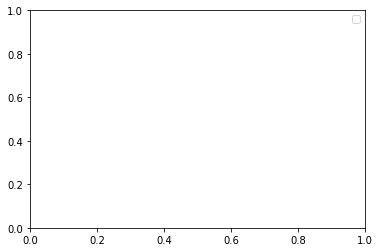

4


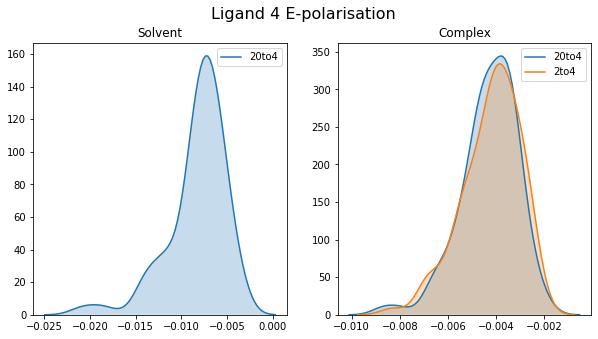

No handles with labels found to put in legend.


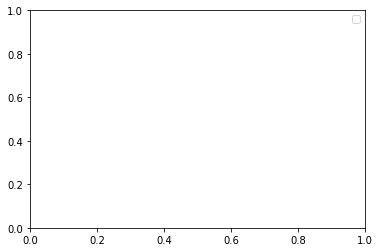

No handles with labels found to put in legend.


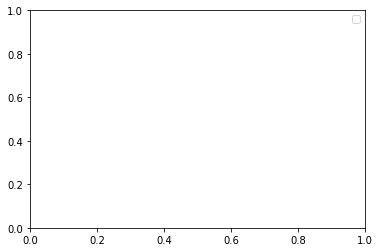

No handles with labels found to put in legend.


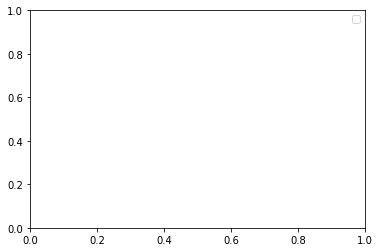

No handles with labels found to put in legend.


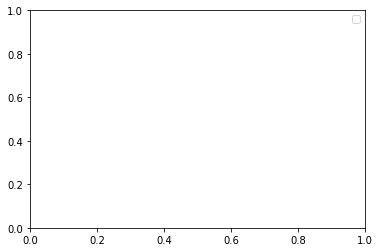

No handles with labels found to put in legend.


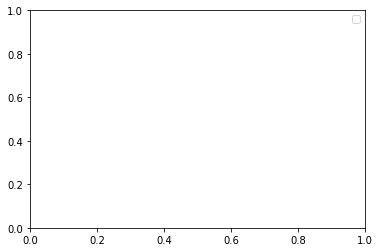

No handles with labels found to put in legend.


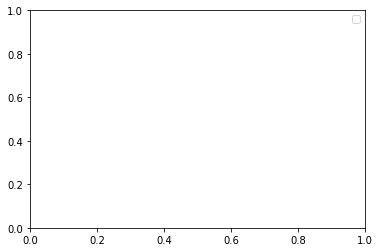

No handles with labels found to put in legend.


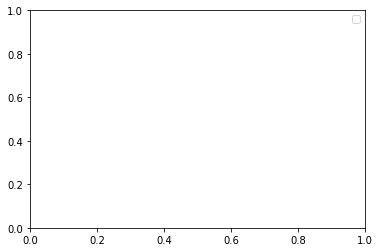

No handles with labels found to put in legend.


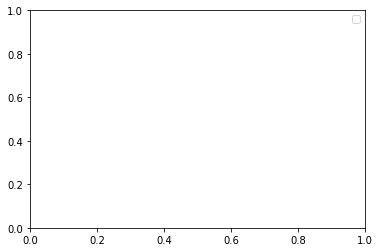

No handles with labels found to put in legend.


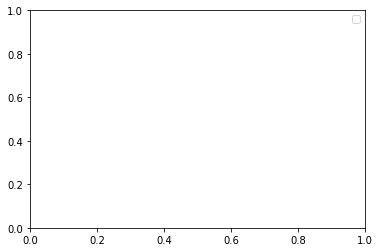

No handles with labels found to put in legend.


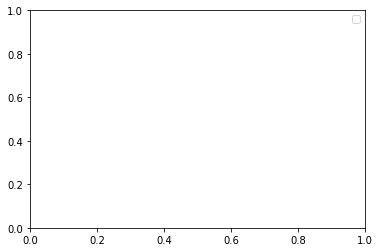

No handles with labels found to put in legend.


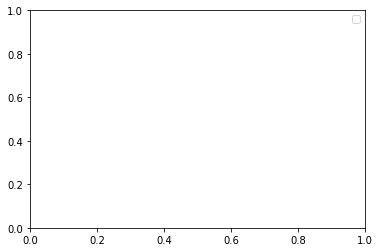

No handles with labels found to put in legend.


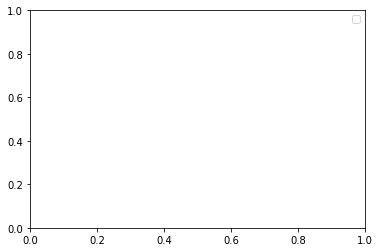

No handles with labels found to put in legend.


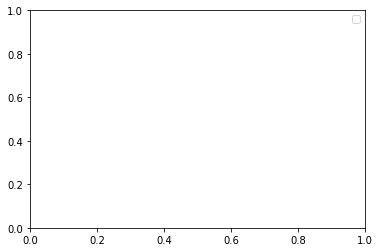

No handles with labels found to put in legend.


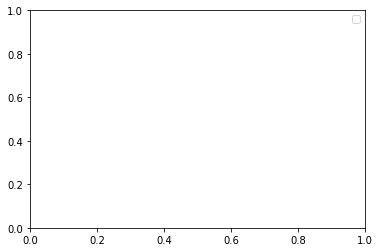

No handles with labels found to put in legend.


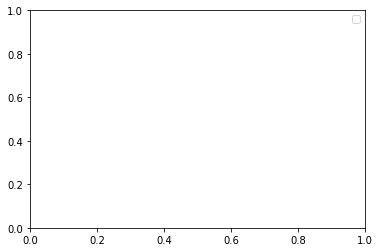

20


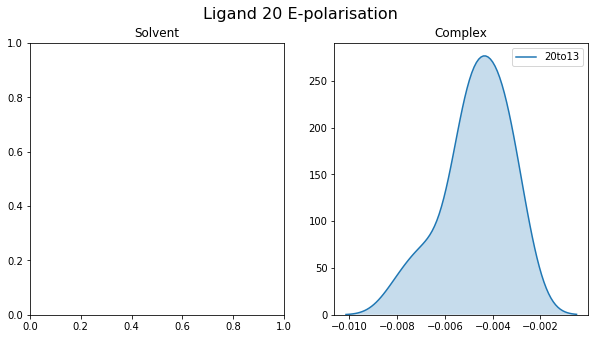

In [116]:
for ligand in all_results.keys():
    if len(all_results[ligand]):
        print(ligand)
        fig, axes = plt.subplots(ncols=2,nrows=1,figsize=(10,5))
        for thing in all_results[ligand]:
            if 'solvent' in thing:
                sns.kdeplot(all_results[ligand][thing]['Epol'],label=thing.split('-lig')[1],shade=True,ax=axes[0])
            elif 'complex' in thing:
                sns.kdeplot(all_results[ligand][thing]['Epol'],label=thing.split('-lig')[1],shade=True,ax=axes[1])
    axes[0].set_title('Solvent')
    axes[1].set_title('Complex')
    fig.suptitle(f"Ligand {ligand} E-polarisation", fontsize=16)
    
    plt.legend()
    plt.show()